### Sentinel 2 - Timeseries analysis
In this notebook, we will have a closer look at Sentinel2 L2A data over Austria in 2024. The parameters of interest are the SCL, RGB, NDVI, LAI, FAPAR, FCOVER, CAB. They are pre-computed and made available at EODC's s3 objectstore. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
from pyproj import CRS, Transformer

import distributed
client = distributed.Client()

In [2]:
# this code allows us to reproject polygons and points from one crs (in epsg code) to the standard 4326 lat-lon

def reproject(spatial_extent_dict: dict = None, x = None, y = None, crs = None):
    if spatial_extent_dict: 
        if not crs:
            crs = spatial_extent_dict["crs"]
        if "4326" in str(crs):
            return spatial_extent_dict
        else:
            transformer = Transformer.from_crs(crs, 4326, always_xy=True)
            west, south = transformer.transform(
                spatial_extent_dict["west"], spatial_extent_dict["south"]
            )
            east, north = transformer.transform(
                spatial_extent_dict["east"], spatial_extent_dict["north"]
            )
            return {
                "west": west,
                "east": east,
                "south": south,
                "north": north,
                "crs": "4326",
            }
    if x and y and crs:
        transformer = Transformer.from_crs(crs, 4326, always_xy=True)
        lon, lat = transformer.transform(
            x, y
        )
        return {"lon": lon, "lat": lat}

In [3]:
# here, you can specify a bounding box and get the matching UTM tile
# this can be skipped, or replaced if you already know the UTM tile of interest

def get_file_list(spatial_extent_dict: dict):
    utm_grid = "utm-tiles.geojson"
    utm = gpd.read_file(utm_grid)
    polygon = Polygon(
        [
            [spatial_extent_dict["west"], spatial_extent_dict["south"]],
            [spatial_extent_dict["west"], spatial_extent_dict["north"]],
            [spatial_extent_dict["east"], spatial_extent_dict["north"]],
            [spatial_extent_dict["east"], spatial_extent_dict["south"]],
        ]
    )
    intersection = []
    for i, geom in enumerate(utm.geometry):
        if geom.intersects(polygon):
            intersection.append(utm.Name[i])
    return intersection

# enter the longitude and latitude and use the utm-grid to get the tile
spatial_extent = {"west": 15.649, "east": 15.65, "south": 48.55, "north": 48.551, "crs": 4326}

spatial_extent_4326 = reproject(spatial_extent)

tiles = get_file_list(spatial_extent)

tile = "T" + tiles[0]
print(tile)

transformer = Transformer.from_crs(4326, 32633, always_xy=True)
west, south = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east, north = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

polygon = Polygon(
    [
        [west, south],
        [west, north],
        [east, north],
        [east, south],
    ]
)

T33UWP


In [4]:
# here, we open a geojson file, which includes the Name of the UTM tile and the geometry (polygon) in UTM coordinates

# pick an item from the list provided and get the tile and polygon from there
fields = gpd.read_file("test_felder.json")
tile = fields["Name"][2]
polygon = fields["geometry"][2]
xp,yp = polygon.exterior.xy
tile

'T33UWP'

In [5]:
# we read the data as a lazy-loaded xarray DataSet

path = f"https://objectstore.eodc.eu:2222/68e13833a1624f43ba2cac01376a18af:indices/s2-bands-{tile}.zarr"

data = xr.open_zarr(path, chunks="auto")

data

<xarray.Dataset> Size: 42GB
Dimensions:      (time: 50, y: 10980, x: 10980)
Coordinates:
  * time         (time) <U48 10kB '2024-06-30T09:57:25.299000000' ... '2024-0...
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 88kB 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    blue         (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    scl          (time, y, x) uint8 6GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    spatial_ref  int32 4B ...

In [6]:
# we organize the data

# we pick the point closest to the polygon centre
i = np.argmin(abs(polygon.centroid.x - data.x.values))
j = np.argmin(abs(polygon.centroid.y - data.y.values))
print(i, j)
a, b = 3000, 3000
if i < 3000 or j < 3000:
    a = np.min([i,j])
if i > np.max(data.x.values) - 3000 or j > np.max(data.y.values) - 3000:
    b = np.min([i, j])

# the timesteps might not be in order, we sort the data
data = data.sortby("time")

t = [(str(time)[:10]) for time in data["time"].values]
t = np.array(t, dtype="datetime64")
print(t[0], t[-1])

# we check the datas coordinate reference system
crs = int(data["spatial_ref"].values)
print("CRS: ", crs)

x = data["x"][i]
y = data["y"][j]

# we retrieve longitude and latitude of the polygon center
lon, lat = reproject(x = x, y = y, crs = crs)["lon"], reproject(x = x, y = y, crs = crs)["lat"]

3713 814
2024-01-10 2024-12-30
CRS:  32633


In [7]:
# pick a timestep of interest to plot
t0 = 21

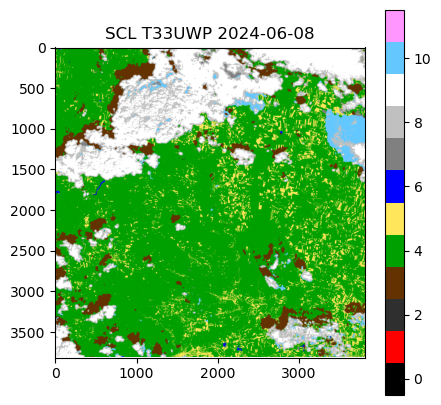

In [8]:
# SCL colormap
from matplotlib import colors

scl_colors = ['#000000', '#FF0000', '#2f2f2f', '#643200', '#00a000', '#ffe65a', '#0000ff', '#808080', '#c0c0c0', '#ffffff', '#64c8ff', '#ff96ff']
scl_cmap = colors.ListedColormap(scl_colors, name="scl")

# when plotting the data, the values get loaded into memory
# we load a subset of data (specified in the indices in the square bracket data.scl[] )
plt.figure(figsize=(5,5))
plt.title(f'SCL {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.scl[t0, j-a:j+b, i-a:i+b], cmap=scl_cmap, vmin=-0.5, vmax=11.5)
plt.colorbar()
plt.show()

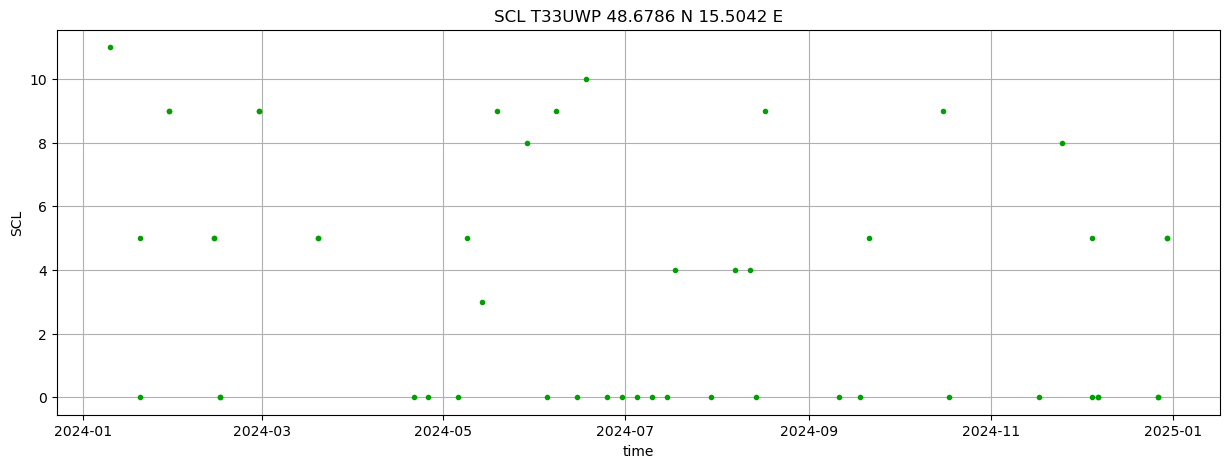

In [9]:
# we plot a time series for the center of the polygon
plt.figure(figsize=(15,5))
plt.title(f'SCL {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
plt.plot(t, data.scl[:, j, i], ".", c='#00a000')
plt.xlabel("time")
plt.ylabel("SCL")
plt.grid()
plt.show()

In [10]:
# we combine the blue, green and red band of the S2 L2A data

def tone_mapping(data):
    red = data.red[t0, j-a:j+b, i-a:i+b].values
    green = data.green[t0, j-a:j+b, i-a:i+b].values
    blue = data.blue[t0, j-a:j+b, i-a:i+b].values
    red = (red+1)/1733*255
    green = (green+1)/1630*255
    blue = (blue+1)/1347*255
    red = np.clip(red,0,255).astype(np.uint8)
    green = np.clip(green,0,255).astype(np.uint8)
    blue = np.clip(blue,0,255).astype(np.uint8)
    brg = np.zeros((red.shape[0],red.shape[1],3),dtype=np.uint8)
    brg[:,:,0] = red
    brg[:,:,1] = green
    brg[:,:,2] = blue
    return brg

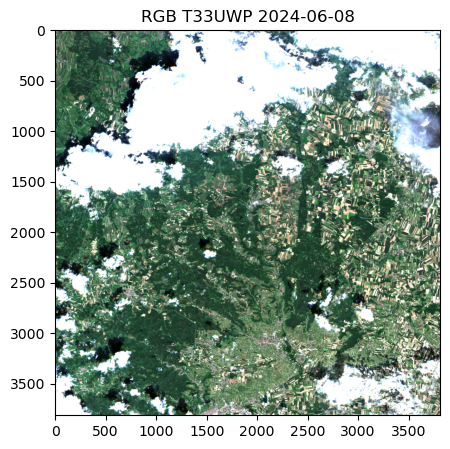

In [11]:
# RGB colormap
plt.figure(figsize=(15,5))
plt.title(f'RGB {tile} {data["time"].values[t0].astype(str)[:10]}')
plt.imshow(tone_mapping(data), cmap='brg')
plt.show()

In [12]:
# we now load the pre-computed indices, which are stored in a different zarr object
path = f"https://objectstore.eodc.eu:2222/68e13833a1624f43ba2cac01376a18af:indices/s2-indices-{tile}.zarr"

data = xr.open_zarr(path, chunks="auto")

# we repeat some of the steps to get the required information
i = np.argmin(abs(polygon.centroid.x - data.x.values))
j = np.argmin(abs(polygon.centroid.y - data.y.values))
print(i, j)
a, b = 3000, 3000
if i < 3000 or j < 3000:
    a = np.min([i,j])
if i > np.max(data.x.values) - 3000 or j > np.max(data.y.values) - 3000:
    b = np.min([i, j])

data = data.sortby("time")

t = [(str(time)[:10]) for time in data["time"].values]
t = np.array(t, dtype="datetime64")
print(t[0], t[-1])

crs = int(data["spatial_ref"].values)
print("CRS: ", crs)

x = data["x"][i]
y = data["y"][j]

lon, lat = reproject(x = x, y = y, crs = crs)["lon"], reproject(x = x, y = y, crs = crs)["lat"]

t0 = 15

data

3713 814
2024-01-10 2024-12-30
CRS:  32633


<xarray.Dataset> Size: 241GB
Dimensions:      (time: 50, y: 10980, x: 10980)
Coordinates:
    spatial_ref  int32 4B ...
  * time         (time) <U48 10kB '2024-01-10T10:07:17.789000000' ... '2024-1...
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 88kB 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    cab          (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    fapar        (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    fcover       (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lai          (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ndvi         (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

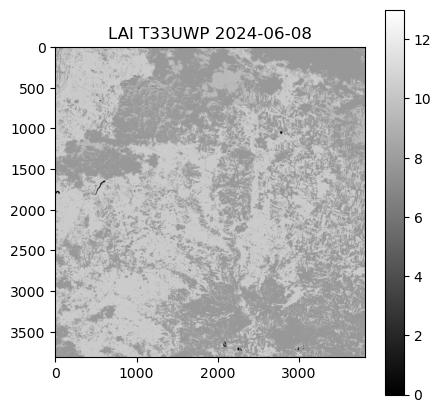

In [13]:
# LAI plot
plt.figure(figsize=(5,5))
plt.title(f'LAI {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.lai[t0, j-a:j+b, i-a:i+b], cmap="gray", vmin=0, vmax=13)
plt.colorbar()
plt.show()

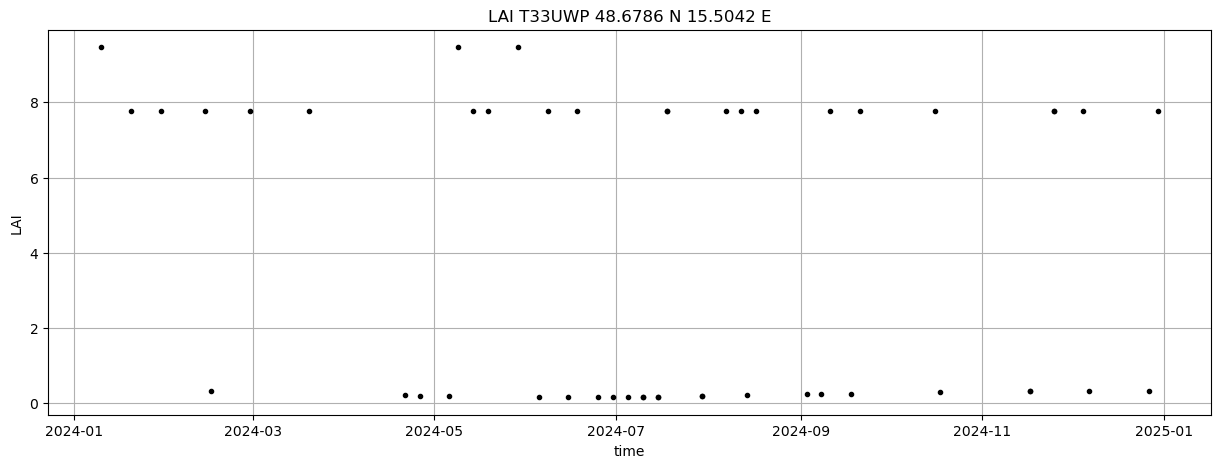

In [14]:
# we plot a time series for the center of the polygon
plt.figure(figsize=(15,5))
plt.title(f'LAI {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
plt.plot(t, data.lai[:, j, i], ".", c='k')
plt.xlabel("time")
plt.ylabel("LAI")
plt.grid()
plt.show()

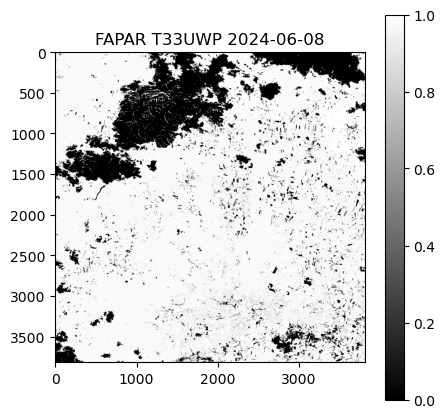

In [15]:
# FAPAR plot
plt.figure(figsize=(5,5))
plt.title(f'FAPAR {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.fapar[t0, j-a:j+b, i-a:i+b], cmap="gray", vmin=0, vmax=1)
plt.colorbar()
plt.show()

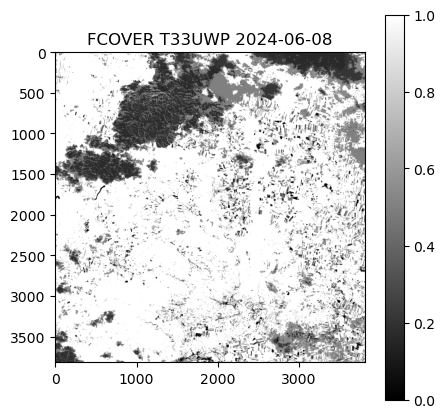

In [16]:
# FCOVER plot
plt.figure(figsize=(5,5))
plt.title(f'FCOVER {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.fcover[t0, j-a:j+b, i-a:i+b], cmap="gray", vmin=0, vmax=1)
plt.colorbar()
plt.show()

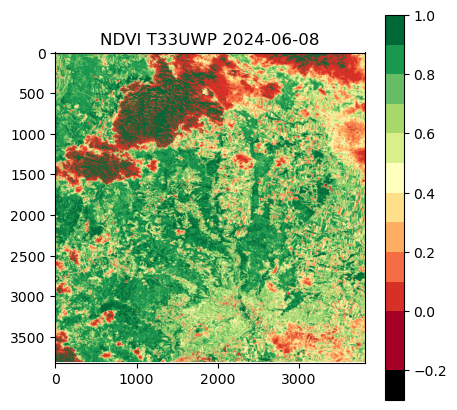

In [17]:
# NDVI colormap
from matplotlib import colors

ndvi_colors = ['#000000', '#a50026', '#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']
ndvi_cmap = colors.ListedColormap(ndvi_colors, name="ndvi")


plt.figure(figsize=(5,5))
plt.title(f'NDVI {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.ndvi[t0, j-a:j+b, i-a:i+b], vmin=-0.3, vmax=1, cmap=ndvi_cmap)
plt.colorbar()
plt.show()

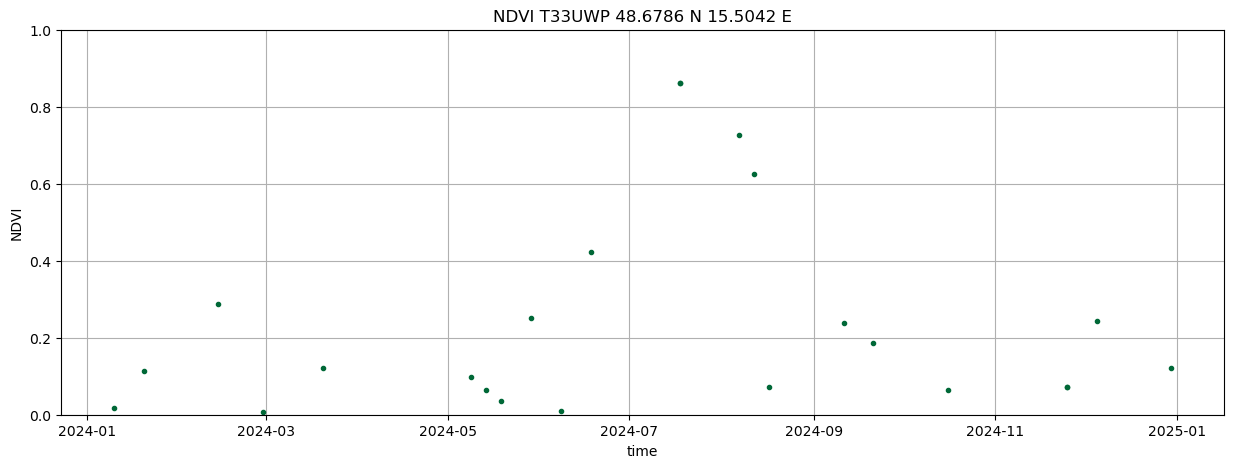

In [18]:
# we plot a time series for the center of the polygon
plt.figure(figsize=(15,5))
plt.title(f'NDVI {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
plt.plot(t, data.ndvi[:, j, i], ".", c='#006837')
plt.xlabel("time")
plt.ylabel("NDVI")
plt.ylim(0,1)
plt.grid()
plt.show()

In [19]:
# this function will load the data values within the polygon specified at the beginning

import rasterio
from datacube.utils.geometry import Geometry

def geometry_mask(polygon, data):
    bbox = polygon.bounds
    data_part = data.sel(x=slice(bbox[0],bbox[2]), y=slice(bbox[3],bbox[1])).compute()
    data_part = data_part.where(data_part <=1, np.nan)
    geom = Geometry(polygon, crs=CRS.from_epsg(32633))
    geobox = data_part.geobox
    mask = rasterio.features.geometry_mask(
        [geom],
        out_shape=geobox.shape,
        transform=geobox.affine,
        all_touched=False,
        invert=True,
    )
    return data_part.where(mask, np.nan)

data_mask = geometry_mask(
    polygon,
    data.ndvi,
)


In [20]:
NDVI = data_mask.mean(dim=["y", "x"], skipna=True)
NDVI

<xarray.DataArray 'ndvi' (time: 50)> Size: 400B
array([0.03070937, 0.20673293, 0.00378043, 0.27321499,        nan,
       0.0037029 , 0.21581456,        nan,        nan,        nan,
       0.27231279, 0.21357565, 0.11532918, 0.30140473,        nan,
       0.04981704,        nan, 0.44757216,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.7929214 , 0.7929214 ,        nan,        nan, 0.64575139,
       0.55623084,        nan, 0.06025467,        nan,        nan,
       0.27051919,        nan, 0.26474857, 0.07604314,        nan,
              nan,        nan,        nan,        nan, 0.08319259,
       0.08319259, 0.29022248,        nan,        nan, 0.21939629])
Coordinates:
    spatial_ref  int32 4B 32633
  * time         (time) <U48 10kB '2024-01-10T10:07:17.789000000' ... '2024-1...

In [21]:
# we create a moving average as a first approach to gap filling 
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def moving_window(index, values, window_size):
    ma = np.nanmean(sliding_window_view(values, window_size), axis=1)
    i = int((window_size-1)/2)
    return index[i:i+len(ma)], ma

tm, ma = moving_window(t, NDVI, 10)

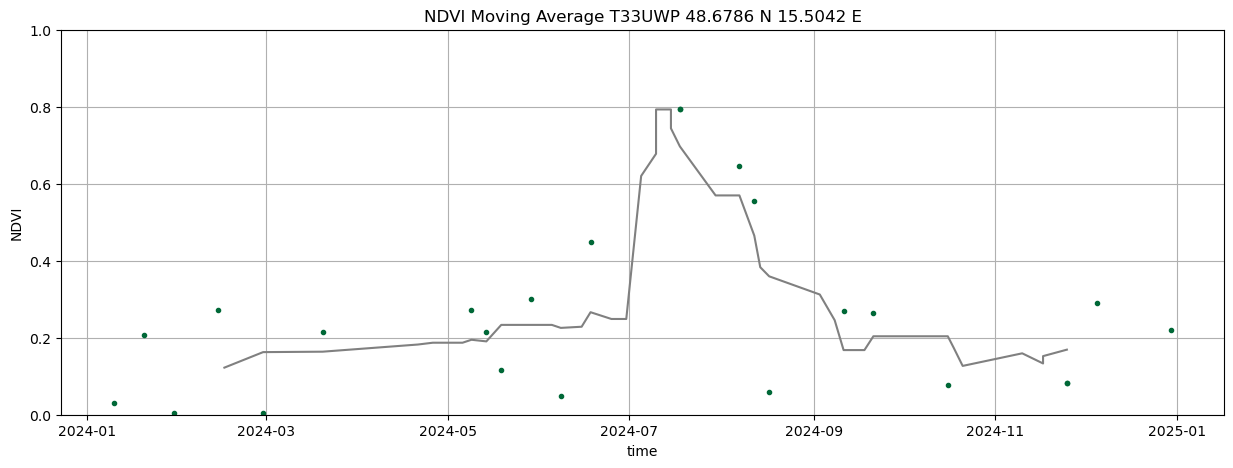

In [22]:
# we plot a time series of the mean over all pixels in the selected polygon
# we plot the moving average next to the values
plt.figure(figsize=(15,5))
plt.title(f'NDVI Moving Average {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
plt.plot(t, NDVI, ".", c='#006837')
plt.plot(tm, ma, c='grey')
plt.xlabel("time")
plt.ylabel("NDVI")
plt.ylim(0,1)
plt.grid()
plt.show()